# DTSA 5510 Unsupervised Learning Final Project

## Project Overview

Fascinated by the BBC news classification Kaggle mini-project in module 4, I decided to take on another document categorization project. As the world is more relied on Twitter feeds and the like, I wanted to see how the traditional document analytics techniques hold up against settings where the words per a document is very small. My hypothesis is that information value of the tweet body is limited and effective predictions or recommendations will need to use other inputs such as images, hashtags and liked documents. 

I will a health news Twitter dataset to identify latent factors for each news agency as well as for each tweet. With the identified factors, I will see how close those news agencies are, and how the model can characterize the new documents with regards to approximates to those news agencies. Then I will see if it enables tweet categorizations in any meaningful way, to assess the potential for news curation systems and document scoring systems.
ws agencies. It could be potentially used as a recommendation system, a news curation system, and document scoring system.

## The Data
The data was downloaded from UCI Machine Learning Repository. The data source is stated as:

`Karami, A., Gangopadhyay, A., Zhou, B., & Kharrazi, H. (2017). Fuzzy approach topic discovery in health and medical corpora. International Journal of Fuzzy Systems, 1-12.`

Data is available at `https://archive.ics.uci.edu/ml/datasets/Health+News+in+Twitter#`.

The data was available in pipe separated text files. One file contains tweets from one source media. The news media agencies and number of tweets from each agency are depicted in a chart below. As the data is from 2014 and 2015, the number of characters is limited to 140. Further, virtually all the tweets include a URL, so the actual number of content words is even smaller.

## Data Cleanup
The files were not in clean pipe separated value. There were many pipe characters in the tweets. Fortunately, all were either preceded or followed by a space character, and I could remove them all with a simple shell script. Other than that, there was no missing value or empty tweet body. I then removed URLs, @’s and #’s because I will be focused on the content words used in the tweets. It would be much more interesting if I could follow the link and parse the target pages, but I will save it for future projects. 

I will leave the other cleanups such as capitalization, normalization, and punctuation handlings to Scikit-Learn’s vectorization libraries.

Some examples of the data frame rows and processed tweets are printed below.



In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

# Create a dataframe for labeling and references

sources = ["Kaiser Health News", "NBC Health", "BBC Health", "CBC Health", "CNN Health","Everyday Health","Fox News Health",
           "The Guardian Health","Good News Health","LA Times Health","MSN Health","NPR Health","NYT Health",
           "Reuters Health", "US News Health","WSJ Health"]
twitter_accounts = ["@KHNews","@NBCNewsHealth","@bbchealth","@CBCHealth","@CNN","@EverydayHealth","@fxnhealth",
            "@GdnHealthcare","@goodnewsnetwork","@latimes","@MSNLifestyle","@NPRHealth","@NYTHealth","@Reuters_Health",
                    "@USNewsHealth","@WSJhealth"]
fnames = ["KaiserHealthNews.txt","NBChealth.txt","bbchealth.txt","cbchealth.txt", "cnnhealth.txt","everydayhealth.txt",
          "foxnewshealth.txt","gdnhealthcare.txt","goodhealth.txt","latimeshealth.txt","msnhealthnews.txt" ,
          "nprhealth.txt","nytimeshealth.txt","reuters_health.txt","usnewshealth.txt", "wsjhealth.txt"]
df = pd.DataFrame({"Media":sources, "Twitter":twitter_accounts, "File":fnames})

source_df = []
for file in df['File']:
    temp_df = pd.read_csv("Health-Tweets/"+file, sep="|")
    temp_df.columns=["id","timestamp","tweet"]
    source_df = source_df + [temp_df]

# basic clean up - remove URLs, @s and #s. keep the words after @ and # 

cleaned_tweets = []
for ldf in source_df:
    tweets = [re.sub(r"(https?[^ ]+)|(@|#)", r"",ldf['tweet'][i]) for i in range(len(ldf['tweet']))]
    cleaned_tweets = cleaned_tweets + [tweets]
    
df["tweets"] = cleaned_tweets

In [520]:
df.head()

,Media,Twitter,File,tweets,num_tweets,mean_words
0,Kaiser Health News,@KHNews,KaiserHealthNews.txt,[A new sort of extracurricular activity: seein...,3508,12.090650
1,NBC Health,@NBCNewsHealth,NBChealth.txt,[Pregnant Woman Taken Off Life Support in Irel...,4214,8.721879
2,BBC Health,@bbchealth,bbchealth.txt,"[GP workload harming care - BMA poll , Short p...",3928,5.794807
3,CBC Health,@CBCHealth,cbchealth.txt,"[Sabra hummus recalled in U.S. , U.S. sperm ba...",3740,9.533957
4,CNN Health,@CNN,cnnhealth.txt,[A plant-based diet that incorporates fish may...,4056,12.564596


In [139]:
df['tweets'][3][5:8]

['Wind turbine noise linked to only 1 health issue – annoyance ',
 "'Wild West' of e-cigarettes sparks debate over regulation ",
 "Dementia patients sold unproven 'brainwave optimization' "]

# Simple Statistics
To give some context to the data, the blew charts show the number of tweets and the average words per a tweet from each source. After removing the URL, the number of remaining words is small. There are noticeable differences, though. The Guardian has more than 2.5 times of average words per tweet compared with BBC. 

With the variation of the number of tweets among the agencies, I will limit select first 1200 tweets from each source in the models, except for the initial TF/IDF analysis.



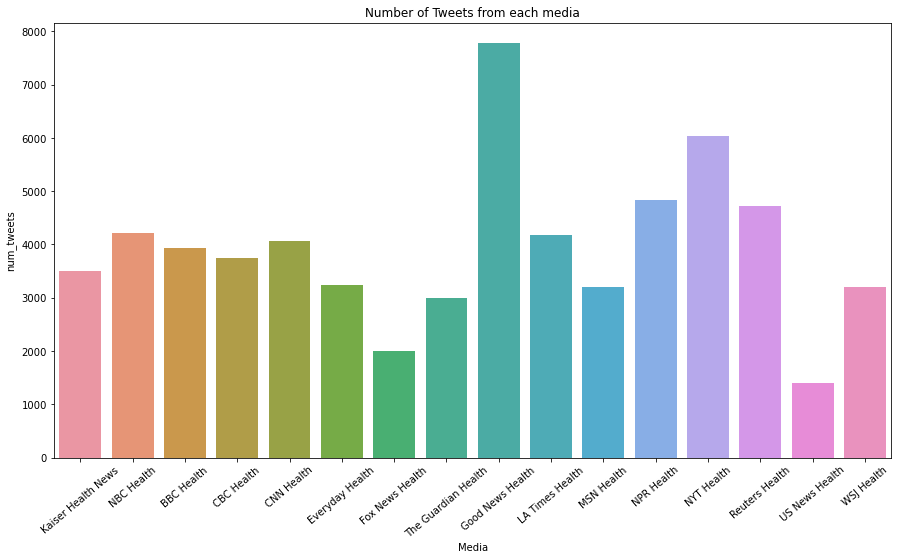

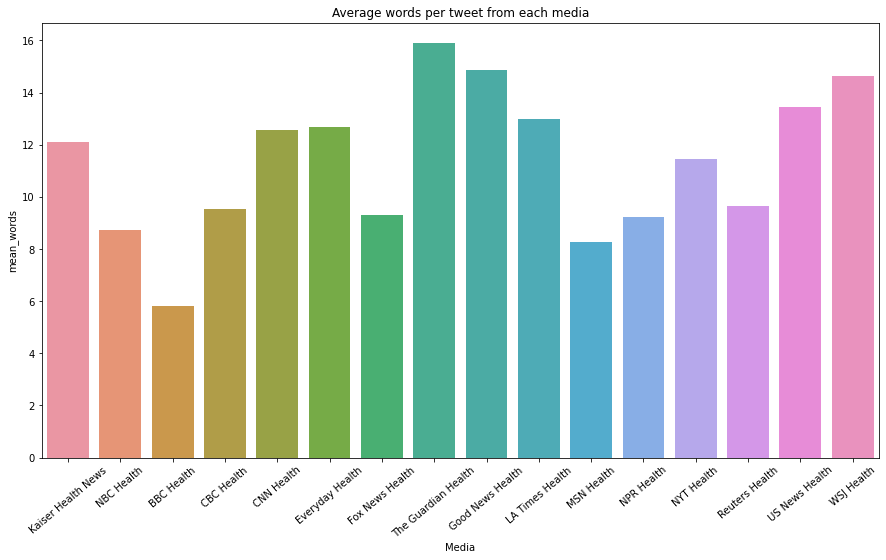

In [140]:
df['num_tweets'] = [len(df.loc[i]['tweets']) for i in range(len(df))]
df['mean_words'] = [ sum([len(str.split(df.loc[i]['tweets'][j])) for j in range(len(df.loc[i]['tweets']))])/df.loc[i]['num_tweets'] 
                   for i in range(len(df))]
plt.figure(figsize = (15,8))
plt.title("Number of Tweets from each media")
ax = sns.barplot(x = 'Media', y = 'num_tweets',data = df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40)
plt.show()

plt.figure(figsize = (15,8))
plt.title("Average words per tweet from each media")
ax = sns.barplot(x = 'Media', y = 'mean_words',data = df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40)
plt.show()

# TF/IDF
First, I ran TF/IDF vectorization to see how the representing words distinguish the source medias. I removed the function words by specifying `stop_words='english'` and removed words that include numbers by a simple regex. 
Top five words with highest TFIDF values are listed below. Aside from regional terms and proper nouns, such as “labour” and “gp” for BBC and The Guardian and “quebec” and “canadian” for CBC Health, those terms are somewhat in line with my expectation, although it probably is coming from the confirmation bias. For example, “glutenfree” sounds like LA Times and “pharma” sounds like WSJ. 


In [141]:
# scikit-learn libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [142]:
training_texts = [" ".join(df.loc[i]['tweets']) for i in range(len(df))]

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', ngram_range=(1,2),
                             stop_words='english', token_pattern=r'(?u)\b[A-Za-z]+\b')
X = vectorizer.fit_transform(training_texts)
X_a = X.toarray()
terms = np.array(vectorizer.get_feature_names())

word_bags = []
for i in range(len(X_a)):
    word_idx = np.argpartition(X_a[i],-10)[-10:]
    word_bags = word_bags + [np.flip(terms[word_idx])]

for i in range(len(df)):
    print (f'{df["Media"][i]}:\n  {word_bags[i]}')

Kaiser Health News:
  ['health law' 'headlines' 'cliff' 'law s' 'kaiserfamfound' 'marketplaces'
 'reports today' 'cms' 'reports rt' 'fiscal cliff']
NBC Health:
  ['safety rules' 'genuine' 'nfl concussion' 'powerful painkiller'
 'new safety' 'communion' 'fda proposes' 'bra' 'foster farms' 'november']
BBC Health:
  ['mps' 'gp' 'ebola video' 'video ebola' 'audio' 'uk ebola' 'care home'
 'labour' 'ebola' 'centre']
CBC Health:
  ['canadian' 'canada s' 'b c' 'canadians' 'p e' 'quebec' 'ebola' 'ford'
 'centre' 'facts ebola']
CNN Health:
  ['rt cnnhealth' 'cnn' 'lost pounds' 'triathlon' 'cnnhealth' 'weightloss'
 'lost lbs' 'timehealthland' 'transformation' 'pls']
Everyday Health:
  ['everydayhealth' 'menshealth' 'jillianmichaels' 'digest' 'rt cspi' 'cspi'
 'eatsmartbd' 'psoriasis' 'worldcancerday' 'rt everydayhealth']
Fox News Health:
  ['disneyland' 'weightloss' 'wakes' 'heart transplant' 'ebola' 'leone'
 'sierra leone' 'georgia' 's' 'lodged']
The Guardian Health:
  ['midwife' 't miss' 'gp' '

I was encouraged by this result and built a simple classification model, which classifies the input articles to the media that gives the highest total TF/IDF score. With **29.8%** accuracy rate for the training data (booseted only to **30.18%** with ngrams=1 and 2), I cannot claim this is an effective model. Then for fun, I let this model classify 5 recent The World Health Organization tweets (@WHO, on April 20, 2022), mostly about Dr. Tedros' speech, and I got the result of `['BBC Health', 'The Guardian Health', 'The Guardian Health', 'The Guardian Health', 'The Guardian Health']` - 80% The Guardian which is understandable.Those two results suggest that stripped tweets of about 10 words are too short to predict the source media, but the model could tell us what a tweet “looks like.”

In [143]:
def predict_tfidf(inp):
    X_at = X_a.T
    words = str.split(inp)
    ret = [0]*16
    for word in words:
        if word in terms:
            ret = ret + X_at[np.where(terms==word)[0][0]]
    return df['Media'][np.argmax(ret)]

total = 0
hit = 0
for i in range(len(df)):
    correct = df['Media'][i]
    for j in range(len(df['tweets'][i])):
        if correct == predict_tfidf(df['tweets'][i][j]):
            hit = hit + 1
        total = total + 1

print (f'score is {hit}/{total} or {hit*100/total}% ')

score is 19019/63012 or 30.183139719418524% 


In [144]:
who = ["live goundbreaking ceremony for the who global traditional medicine centre with drtedros and prime minister narendramodi",
       "improving equitable access to safe quality and effective traditional and complimentary medicine services can help to meet communities needs and help to build culturally and environmentally sensitive #primaryhealthcare drtedros healthforall",
       "traditional medicine faces challenges with regulatory issues, such as the lack of systematic data and evidence insufficient financial support for research and not enough mechanisms to monitor the safety of traditional medicine practice drtedros",
       "traditional medicine has been an integral resource for health for centuries in communities its still a mainstay for some with inequities in access to conventional medicine but also because of trust in traditional knowledge practices resources drtedros",
       "the who global centre for traditional Medicine will help to harness the power of science to strengthen the evidence base for traditional medicine and help ensure that everyone has access to safe and effective treatment this is an essential part of whos missio drtedros"]
print ([predict_tfidf(who[i]) for i in range(len(who))])

['CBC Health', 'The Guardian Health', 'The Guardian Health', 'The Guardian Health', 'The Guardian Health']


# Matrix Factorization and Adoptations

## TF/IDF and MF for Source Media

Using the TFIDF vectors, I applied matrix factorization in attempt to find out latent factors. There is absolutely no domain knowledge basis on this model, but considering that is a nature of unsupervised learning, I assume it is representing something. It just requires human inputs to give meanings to the categorization.

I decomposed the matrix with 2 components and plotted the media agencies to show their approximates in the chart below. It kind of makes sense and we could even add deliberate interpretations. To me, it looks like factor 0, the horizontal axis, shows the how traditional as a medium – more traditional toward right. Factor 1 appears to show the “dryness” of the media – the higher the more sensational. Although it is fun to ponder around this, without rigorous validation, the output cannot be reliable. Yet, it shows the model can distinguish the documents.




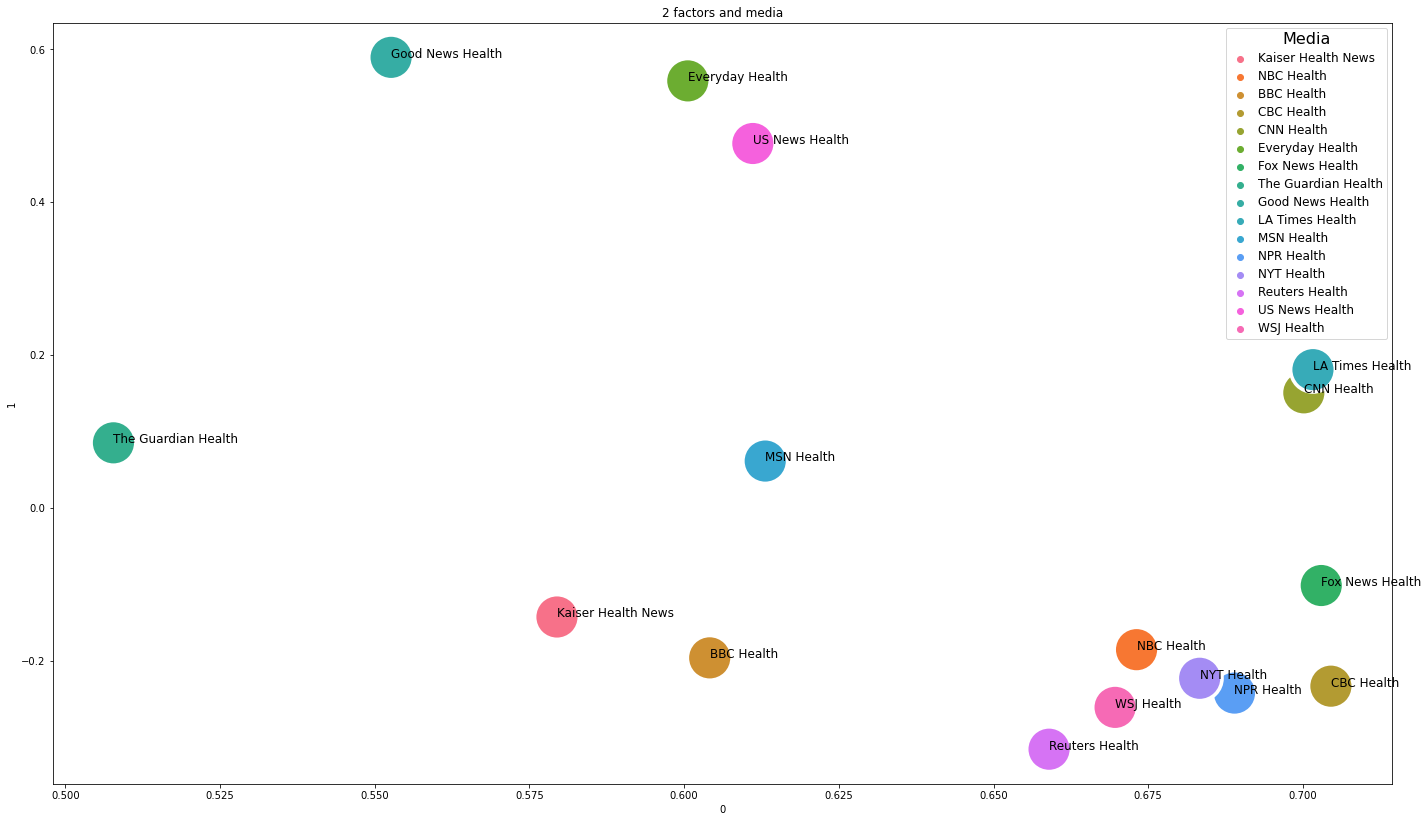

In [349]:
# Similar plot TFIDF based.
training_texts = [" ".join(df.loc[i]['tweets'][1:1200]) for i in range(len(df))]

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', ngram_range=(1,2),
                             stop_words='english', token_pattern=r'(?u)\b[A-Za-z]+\b')
X = vectorizer.fit_transform(training_texts)
X_a = X.toarray()
terms = np.array(vectorizer.get_feature_names())

# Matrix factorization model
n = 2
tsvd = TruncatedSVD(n_components=n).fit(X_a)
X = tsvd.transform(X_a)
U = np.matmul(X_a, np.matmul(tsvd.components_.T, np.diag(1/tsvd.singular_values_)))
Vt = tsvd.components_
S = tsvd.singular_values_

plots = {}
for ld in range(n):
    plots[ld] = [U[i][ld]*S[ld] for i in range(len(U))]
#    plots[ld] = [U[i][ld] for i in range(len(U))]

plots['Media'] = df['Media']

for_chart = pd.DataFrame(plots)
fig = plt.figure(figsize=(24,14))
 
f=sns.scatterplot(data=for_chart, x=0,y=1,hue='Media',s=2000)

for line in range(len(df)):
     f.text(plots[0][line], plots[1][line], 
     plots['Media'][line], horizontalalignment='left', 
     size='large', color='black') #, weight='semibold')
plt.title('2 factors and media')
plt.setp(f.get_legend().get_title(), fontsize='16')
plt.setp(f.get_legend().get_texts(), fontsize='12')
plt.show()


## Count Vector and MF for Tweets

Then I applied matrix factorization taking each tweet as a document. To be able to apply the model for new inputs, I used simple word count vector instead of TFIDF. With two components, I got the distribution in the below chart. I tried some more parameter combinations, but the results were not fundamentally different. With this, I concluded it was unrealistic to predict the source media.

At the same time, there appears to be some clusters. Assuming those components are latent factors to describe the nature of tweets, I applied the Kmeans clustering to the outcome. I increased the n_components to 5, and set k=4 for the clustering.


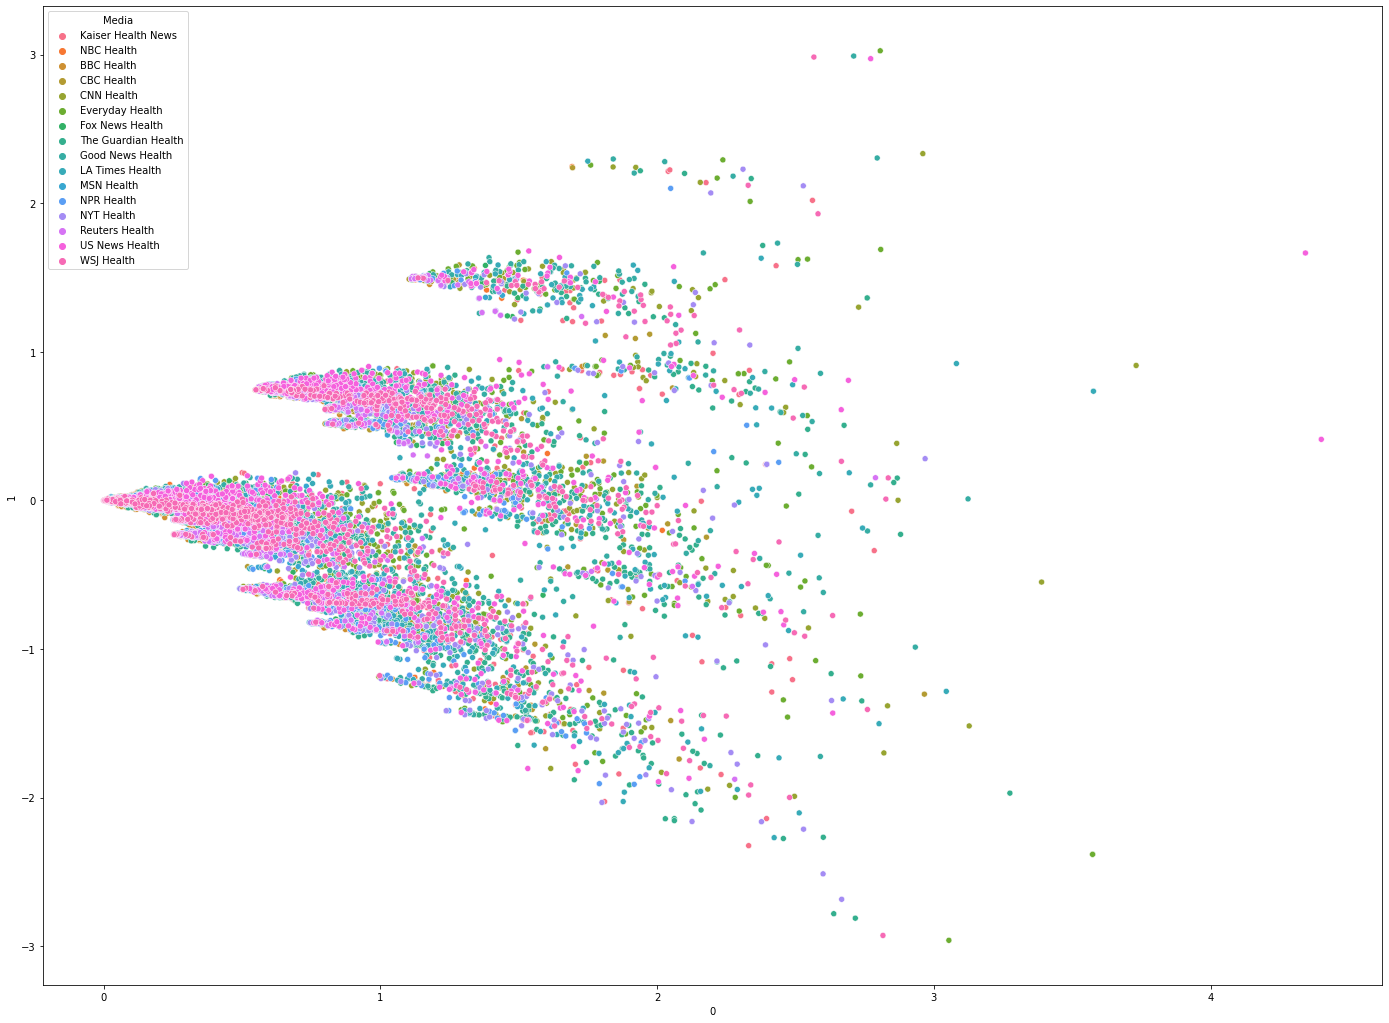

In [357]:
training_texts = [" ".join(df.loc[i]['tweets'][1:1200]) for i in range(len(df))]
media_v = []
tweet_v = []
for i in range(len(df)):
    tw = df.loc[i]['tweets']
    for j in range(1200): #(len(tw)):
        media_v = media_v + [df.loc[i]['Media']]
        tweet_v = tweet_v + [tw[j]]
newdf = pd.DataFrame({'Media':media_v, 'Tweet':tweet_v})


# Create word count vectors with stop_words = english

vectorizer = CountVectorizer() # no stop word
X = vectorizer.fit_transform(newdf['Tweet'])
X_a = np.array(X.toarray())

n = 2
tsvd = TruncatedSVD(n_components=n).fit(X_a)
X = tsvd.transform(X_a)
U = np.matmul(X_a, np.matmul(tsvd.components_.T, np.diag(1/tsvd.singular_values_)))
Vt = tsvd.components_
S = tsvd.singular_values_

plots = {}
for ld in range(n):
    plots[ld] = [U[i][ld]*S[ld] for i in range(len(U))]
plots['Media'] = newdf['Media']

for_chart = pd.DataFrame(plots)
fig = plt.figure(figsize=(24,18))
 
f=sns.scatterplot(data=for_chart, x=0,y=1,hue='Media')

plt.show()


Kmeans created clusters with the distribution of `[9407 4104 2820 2869]`. To make sure that kmeans did not simply pick up the size of tweets, I counted the average words per a tweet for each cluster. It came out as `[10.36, 12.30, 12,70, 13.69]`.  The first category (category 0) has shorter tweets, and most likely it contains tweets with many count vectors with small magnitude. In fact, it appears to cover all the very short tweets without much content. I will accept it as one of the characteristics of category 0.

Then I plotted the category distributions of tweets from each source media in the horizontal chart below. Once we understand the nature of each category, we can characterize each media. This tells the similarities between the agencies and it will help us to decide which accounts to follow and monitor closely. It could also be combined with the TFIDF results presented above.



In [479]:
# Matrix factorization model
n = 5
tsvd = TruncatedSVD(n_components=n).fit(X_a)
X = tsvd.transform(X_a)
U = np.matmul(X_a, np.matmul(tsvd.components_.T, np.diag(1/tsvd.singular_values_)))
Vt = tsvd.components_
S = tsvd.singular_values_

# Kmeans clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, n_init=20, max_iter=500, random_state=5)
kmeans.fit(U)
print (np.bincount(kmeans.labels_))

cntdf = pd.DataFrame({"tw":tweet_v,"cat":kmeans.labels_,"med":media_v})
cntdf['wc'] = [len(str.split(a)) for a in list(cntdf['tw'])]
mean_wc = cntdf.groupby('cat').mean('wc')
print (mean_wc)
   


[9407 4104 2820 2869]
            wc
cat           
0    10.358456
1    12.699318
2    13.686525
3    12.299407


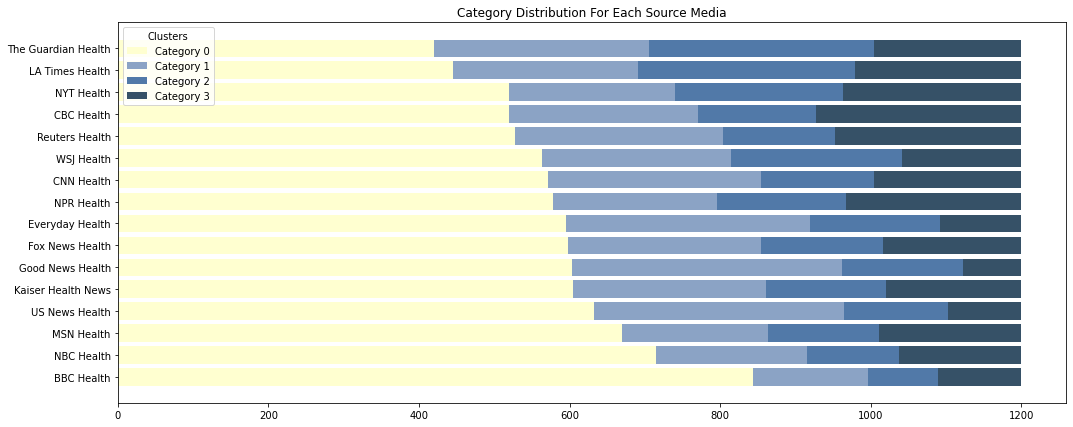

In [511]:
mediacnt=(cntdf.groupby(["med","cat"]).count()).unstack()['tw']

med = []; cat1 = []; cat2 = []; cat3 = []; cat4 = []

mediacnt.sort_values(by=0, ascending=False, inplace=True)
mediacnt.reset_index(inplace=True)

for m in mediacnt.index:
    l = list(mediacnt.loc[m])
    med = med+[l[0]]
    cat1 = cat1 + [l[1]]
    cat2 = cat2 + [l[2]]
    cat3 = cat3 + [l[3]]
    cat4 = cat4 + [l[4]]

cat2_i = list(np.array(cat1)+np.array(cat2))
cat3_i = list(np.array(cat1)+np.array(cat2)+np.array(cat3))
    
plt.rcParams["figure.figsize"] = [17,7]
#plt.rcParams["figure.autolayout"] = True

b1 = plt.barh(med, cat1, color='#ffffd0')
b2 = plt.barh(med, cat2, left=cat1, color='#8ba3c5')
b3 = plt.barh(med, cat3, left=cat2_i, color= '#5179a8')
b4 = plt.barh(med, cat4, left=cat3_i, color='#365167')
plt.legend([b1, b2, b3, b4], ["Category 0", "Category 1", "Category 2", "Category 3"], title="Clusters", loc="upper left")
plt.title("Category Distribution For Each Source Media")

plt.show()


In [512]:
# Prediction - use the file named test2.in. Each line should include a tweet.

f=open('test2.in.7') # Feed tweets to be evaluated from a text file.
test = f.readlines()
f.close()
v_a = np.array(vectorizer.transform(test).toarray())

X = tsvd.transform(v_a)
U = np.matmul(v_a, np.matmul(tsvd.components_.T, np.diag(1/tsvd.singular_values_)))
Vt = tsvd.components_
S = tsvd.singular_values_

# Kmeans clustering
a=kmeans.predict(U)
for ii in range(len(test)):
    print (f'category : {a[ii]}')

category : 1
category : 0
category : 2
category : 1
category : 1


# Interpretation and Conclusion
## Interpretation
What do these categories mean? There is no meaning or whatsoever incorporated in the model development process, but that’s how the unsupervised learning is used, and we need to interpret and define what the categorizations, or the factors used in the categorization, represent.

I read through sampled tweets in each category, and fortunately I was able to see some patterns.  This approach is probably not acceptable in a professional project because the labeling is highly subjective and biased. It must be reviewed by multiple individuals for real world applications. Anyway, I would roughly define each category as:

* Category 0: Tweets on social matters and policies. It also includes control messages.
* Category 1: Tweets on diseases and illness.
* Category 2: Tweets on personal health such as diet.
* Category 3: Tweets on scientific and medical subjects.

I did not verify the accuracy quantitatively because validating using my own criteria is a conflict of interests, but I was reasonably surprised by the model’s ability to distinguish the tweets. Maybe my mind has been numbed after burying in the tweets for hours, but the categorization looks to be working. 

Here are some categorization examples on tweets that I pulled today.

Category 0:

`“How Kentucky Republicans blocked all abortions for more than a week” (NPR Health)`

`“Union President John Courtney discusses masking on public transportation” (NPR Health)`

Category 1:

`“Here’s what you need to know about the pandemic right now” (Reuters Health)`

`“Bipolar disorder is widely misunderstood, and it’s time to clear up those false benefits.” (Everyday Health)`

Category 2:

`“Why the rise of rapid tests makes COVID-19 case counts hard to trust” (TIME Health)`

`“Pfizer said on Friday it was voluntarily recalling five batches of Accupril blood pressure tablets after finding elevated level of a potential cancer-causing agent in the medicine” (Reuters Health)`

Category 3:

`“Amid rising marijuana use in the U.S., researchers are exploring risks to bystanders, children – and pets” (WSJ Health)`

`“@TexasChildrens is the top-ranked hospital in treating high-risk heart defects and helping children with severe congenital heart disease”  (U.S. News Health)`

## Conclusion
I failed to reject my null hypothesis set at the beginning. The texts in the tweets alone are not enough to build effective predictive models. Considering the experience with the BBC magazine articles in the module 4, this is because tweets are too short, and even aggregated, it does not explain the document well enough. 

For the detailed prediction and explanation, we need to tap into the image analysis and follow through the included URL.  Tweets today include much more valuable information than 140 – 280 characters. I also would expect hashtags and mention (or further social network analysis) will improve the power of the models significantly. 

However, I would conclude that we can build models that produce interesting clusters using only the text body. Evaluations over time and by multiple individuals are required to assess the real value of the models, but unsupervised models like I demonstrated here could make a good basis for a recommendation system and a curation system.
